## This jupyter notebook contains data discovery, exploratory analysis and build multiclass classifier to predict correct serviceid category based job detials for a Online Craftsman Service Marketplace.

In [4]:
from __future__ import division
import pandas as pd
import numpy as np
import math
import subprocess
import os
import io
from gensim.models import FastText,word2vec
# from pyspark import SparkContext
# from pyspark.sql import HiveContext
import gcsfs
# sc = SparkContext()
# sc.setLogLevel("ERROR")
# spark = HiveContext(sc)
import time
import gc
from gensim.test.utils import get_tmpfile
print('Library Import')
import gcsfs
gcsfs.GCSFileSystem(project='my_project')
import pyspark
import pyspark.sql.functions as F
import sqlalchemy
import getpass
import pyspark.sql.window as Window
from pyspark.sql.functions import udf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql import DataFrame
import os
from hyperopt import STATUS_OK
from timeit import default_timer as timer
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import numpy as np 
from hyperopt import tpe,Trials,fmin
import pandas as pd
import pyarrow.parquet as pq
from fastparquet import ParquetFile
import pyspark.ml as ml
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.sql.window import Window
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
from sklearn.metrics import roc_auc_score
from pyspark.ml.feature import PolynomialExpansion
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
import sklearn.neighbors
import pandas as pd
from scipy.stats import chi2_contingency
from pyspark.sql.types import IntegerType,StringType,FloatType
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    ParameterGrid,
    ParameterSampler,
    RandomizedSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
    train_test_split)
from sklearn.metrics import (
    accuracy_score,
    log_loss,
    make_scorer,
    roc_auc_score,
)
import xgboost as xgb
from ctypes import *
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV 
from xgboost.sklearn import XGBClassifier,XGBRegressor
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as pr
from sklearn.preprocessing import LabelEncoder
import pickle
mode = 'overwrite'
from tensorflow.python.keras import backend as K
import subprocess
from gensim.models import FastText,word2vec
from gensim.models.keyedvectors import FastTextKeyedVectors, KeyedVectors
import gcsfs
import nltk
# nltk.download('punkt')
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import gensim
from gensim.models import FastText,word2vec
import seaborn as sns
from sklearn.decomposition import PCA
# fast_text_mod = FastText.load('/tmp/fasttext.model/')
# fast_text_mod = KeyedVectors.load('gs://meijer-analystplatform-analyst/raziah/subs/productionModel/science/subs_model_fasttext_2018_sp.model')

Library Import


## Exploratory analysis and data preperation

### sneak peek of data

In [5]:
data_path = 'nlp_dat_classif.csv'
data = pd.read_csv(data_path,encoding='ISO-8859-1')
print(data.head(5))
print(data.shape)
print(data.dtypes)
data.columns

         id                                              title  \
0  11096465  Balkon mit Fliesenbelag (ca. 5,8 m2) sanieren ...   
1  11105910  Wir suchen Subunternehmer f?ºr Winterdienst Ar...   
2  11289195                    Schornstein zu Ziegel abdichten   
3  11991226                Gehweg auf ca. 17 x 3 Meter streuen   
4  12056087              Geradl?§ufige Betontreppe f?ºr Neubau   

                                         description        createdAt  \
0  (1) Entfernen von Fliesenbelag und Gef?§lleest...  5/30/2019 10:29   
1  Wir Arbeiten mit vielen Gro?üen Firmen zusamme...   5/31/2019 8:53   
2  Die Abdichtung vom Schornstein zu den Dachzieg...  6/14/2019 11:10   
3  Es soll im Winter bei gesetzlicher Notwendigke...   8/5/2019 17:18   
4  - Gerade Betontreppe (Fertigteil oder vor Ort ...  8/10/2019 13:34   

           endedAt  serviceId  \
0  7/10/2019 11:25       8130   
1    7/9/2019 8:29       9010   
2  7/17/2019 10:52       1060   
3   9/4/2019 17:18       9010   

Index(['id', 'title', 'description', 'createdAt', 'endedAt', 'serviceId',
       'user_description', 'service_based_form', 'target_date',
       'reissuedCopyOf', 'tradeClassificationType', 'state', 'stateText',
       'sbf_form_text'],
      dtype='object')

### selecting the useful fields for further analysis,data prep and model building

#### Missing value Explore

In [14]:
missing = pd.DataFrame(data.apply(lambda x: np.sum(x.isnull(), axis=0)))
missing['percentage_missing'] = (missing.iloc[:,0]/data.shape[0])*100
print(missing)

                           0  percentage_missing
id                         0            0.000000
title                      0            0.000000
description                0            0.000000
createdAt                  0            0.000000
endedAt                    0            0.000000
serviceId                  0            0.000000
user_description         618           97.476341
service_based_form         0            0.000000
target_date                0            0.000000
reissuedCopyOf             0            0.000000
tradeClassificationType    0            0.000000
state                      0            0.000000
stateText                  0            0.000000
sbf_form_text             16            2.523659


#### Only significant missing value for field user_description         

In [13]:
cols_to_explore = ['state', 'stateText','reissuedCopyOf', 'tradeClassificationType','service_based_form']
for i in cols_to_explore:
    print('this is for:',i)
    print(data[i].value_counts())
txt_field_check = ['user_description','sbf_form_text'] 
for i in txt_field_check:
    print('compararision with field %s and description' %(i))
    print(data.loc[data[i].notna(),['description',i]].head(3))    

this is for: state
0    634
Name: state, dtype: int64
this is for: stateText
active    634
Name: stateText, dtype: int64
this is for: reissuedCopyOf
0    634
Name: reissuedCopyOf, dtype: int64
this is for: tradeClassificationType
1.0    337
2.0    183
4.0    114
Name: tradeClassificationType, dtype: int64
this is for: service_based_form
1    618
0     16
Name: service_based_form, dtype: int64
compararision with field user_description and description
                                         description  \
0  (1) Entfernen von Fliesenbelag und Gef?§lleest...   
1  Wir Arbeiten mit vielen Gro?üen Firmen zusamme...   
2  Die Abdichtung vom Schornstein zu den Dachzieg...   

                                    user_description  
0  (1) Entfernen von Fliesenbelag und Gef?§lleest...  
1  Wir Arbeiten mit vielen Gro?üen Firmen zusamme...  
2  Die Abdichtung vom Schornstein zu den Dachzieg...  
compararision with field sbf_form_text and description
                                          desc

-	 As the fields 'state','stateText' and 'reissuedCopyOf' has only one distinct value each for this data these fields has no predictive power.
-	 Also for more than 97% of the data service_based_form has only one value(1). So there is no significant variance for this field
-    Also from the comparasion of text for fields user_description and sbf_form_text w.r.t the field description it's the same information.So these two fields - user_description and sbf_form_text are redundant and can remove from the dataset     

In [6]:
data_useful = data[['id', 'title', 'description','user_description','serviceId','createdAt','target_date','tradeClassificationType','sbf_form_text']]
data_useful = data_useful.replace(np.nan, '', regex=True)
print(data_useful.head(5))

         id                                              title  \
0  11096465  Balkon mit Fliesenbelag (ca. 5,8 m2) sanieren ...   
1  11105910  Wir suchen Subunternehmer f?ºr Winterdienst Ar...   
2  11289195                    Schornstein zu Ziegel abdichten   
3  11991226                Gehweg auf ca. 17 x 3 Meter streuen   
4  12056087              Geradl?§ufige Betontreppe f?ºr Neubau   

                                         description  \
0  (1) Entfernen von Fliesenbelag und Gef?§lleest...   
1  Wir Arbeiten mit vielen Gro?üen Firmen zusamme...   
2  Die Abdichtung vom Schornstein zu den Dachzieg...   
3  Es soll im Winter bei gesetzlicher Notwendigke...   
4  - Gerade Betontreppe (Fertigteil oder vor Ort ...   

                                    user_description  serviceId  \
0  (1) Entfernen von Fliesenbelag und Gef?§lleest...       8130   
1  Wir Arbeiten mit vielen Gro?üen Firmen zusamme...       9010   
2  Die Abdichtung vom Schornstein zu den Dachzieg...       1060  

### Exploring the target

Frequency Table for serviceId:
7010     202
9010     113
10010     87
7060      81
8130      55
1060      44
12070     25
12130     19
3020       8
Name: serviceId, dtype: int64


<AxesSubplot:>

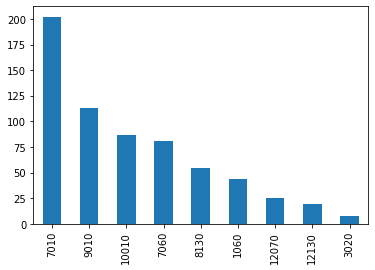

In [17]:
temp1 = data_useful['serviceId'].value_counts()
print ('Frequency Table for serviceId:') 
print (temp1)
temp1.plot(kind='bar')

-	Multiclass classification task with total 9 service categories 
-   Apart from last three categories all other categories have example > 40.

### Relationship of ServiceID with tradeClassificationType     

serviceId                    1060      3020      7010     7060      8130  \
tradeClassificationType                                                    
1.0                      0.069401  0.012618  0.315457  0.12776  0.006309   
2.0                      0.000000  0.000000  0.001577  0.00000  0.080442   
4.0                      0.000000  0.000000  0.001577  0.00000  0.000000   
All                      0.069401  0.012618  0.318612  0.12776  0.086751   

serviceId                    9010     10010     12070     12130       All  
tradeClassificationType                                                    
1.0                      0.000000  0.000000  0.000000  0.000000  0.531546  
2.0                      0.000000  0.137224  0.039432  0.029968  0.288644  
4.0                      0.178233  0.000000  0.000000  0.000000  0.179811  
All                      0.178233  0.137224  0.039432  0.029968  1.000000  
Chi-sq Test Statistics = 1.949 
P-Value = 1.000 
Degrees of Freedom = 27.000


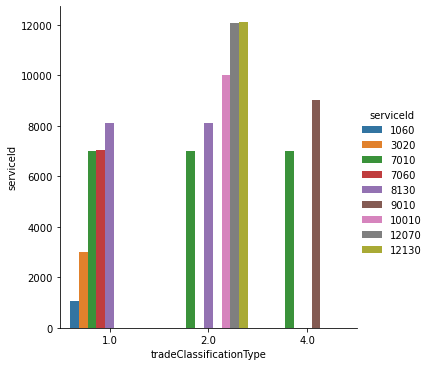

In [26]:
table = pd.crosstab(data_useful['tradeClassificationType'],data_useful['serviceId'],margins=True,normalize=True)
print(table)
stat, pvalue, dof, expected = chi2_contingency(table)
print('Chi-sq Test Statistics = %.3f \nP-Value = %.3f \nDegrees of Freedom = %.3f' % (stat, pvalue, dof))
sns.catplot(x="tradeClassificationType", y="serviceId",hue='serviceId', kind="bar", data=data_useful)

-	From the visualization,descriptive stat and Chi-sq Test Statistics the relationship is stron and tradeClassificationType is a strong predictor to classify ServiceID

## Data preparation and feature engineering. Also data exploration to assess usefulness of features

### Fist to create a combined field by concatanating two fields title and description as these two contains task summary and description.Then two apply following nlp text preprocessing steps to create clean text

-  i) special character,punctuation and digit removal
-  ii) lagging and leading space removal
-  iii) making the text in lower case
-  iv) Removing German stopwords
-  v) Tokenizing the text

In [8]:
data_useful['composite_text'] = data['title'] + data['description'].map(str)
data_useful['composite_text'] = [re.sub("@[\w]*",'',str(data_useful.composite_text.values[i])).strip() for i in range(len(data_useful))] 
data_useful['composite_text'] = [re.sub("\d",'',str(data_useful.composite_text.values[i])).strip() for i in range(len(data_useful))] 
data_useful['composite_text'] = [str(data_useful.composite_text.values[i]).lower().strip() for i in range(len(data_useful))] 
table = str.maketrans('', '', string.punctuation)
data_useful['clean_txt'] = data_useful['composite_text'].apply(lambda x: [w.translate(table) for w in x.split(' ') if w not in('.','')])
# stop_words = stopwords.words('german')
print('explore stopwords:',stop_words[0:5])
data_useful['clean_txt'] = data_useful['clean_txt'].apply(lambda x: [w for w in x if w not in(stop_words)])
data_useful.head(3)

explore stopwords: ['aber', 'alle', 'allem', 'allen', 'aller']


,id,title,description,user_description,serviceId,createdAt,target_date,tradeClassificationType,sbf_form_text,composite_text,clean_txt
0,11096465,"Balkon mit Fliesenbelag (ca. 5,8 m2) sanieren ...",(1) Entfernen von Fliesenbelag und Gef?§lleest...,(1) Entfernen von Fliesenbelag und Gef?§lleest...,8130,5/30/2019 10:29,Zeitnah,1.0,,"balkon mit fliesenbelag (ca. , m) sanieren / ....","[balkon, fliesenbelag, ca, , m, sanieren, , og..."
1,11105910,Wir suchen Subunternehmer f?ºr Winterdienst Ar...,Wir Arbeiten mit vielen Gro?üen Firmen zusamme...,Wir Arbeiten mit vielen Gro?üen Firmen zusamme...,9010,5/31/2019 8:53,In 3 bis 6 Monaten,4.0,,wir suchen subunternehmer f?ºr winterdienst ar...,"[suchen, subunternehmer, fºr, winterdienst, ar..."
2,11289195,Schornstein zu Ziegel abdichten,Die Abdichtung vom Schornstein zu den Dachzieg...,Die Abdichtung vom Schornstein zu den Dachzieg...,1060,6/14/2019 11:10,Zeitnah,1.0,,schornstein zu ziegel abdichtendie abdichtung ...,"[schornstein, ziegel, abdichtendie, abdichtung..."


### As the text is preprocessed and Tokenized it's suitable to apply NLP algorithms like W2vec or FastText for feture extraction from text. We will explore following two techniques two create word vectors or embedding and choose the best for final classifier.

- a) gensim Word2Vec(100 dimention vector)
- b) gensim FastText(100 dimention vector)

#### Before embedding creation let's first let's do other feature engineering and exploration - target_date and tradeClassificationType

In [120]:
data_useful.target_date.unique()

array(['Zeitnah', 'In 3 bis 6 Monaten', 'In den n?§chsten 3 Monaten',
       'Innerhalb der n?§chsten 30 Tage', 'Wunschtermin: 18.01.2021',
       'In mehr als 6 Monaten', 'Wunschtermin: 08.01.2021',
       'Wunschtermin: 11.12.2020', 'Wunschtermin: 31.01.2021',
       'Wunschtermin: 22.02.2021', 'Wunschtermin: 04.02.2021',
       'Wunschtermin: 15.01.2021', 'Wunschtermin: 30.11.2020',
       'Wunschtermin: 08.02.2021', 'Wunschtermin: 23.12.2020',
       'Wunschtermin: 19.01.2021', 'Wunschtermin: 01.01.2021',
       'Wunschtermin: 05.01.2021', 'Wunschtermin: 07.12.2020'],
      dtype=object)

- target_date field have mainly 4 categories- Zeitnah', 'In 3 bis 6 Monaten', 'In den n?§chsten 3 Monaten' and 'Innerhalb der n?§chsten 30 Tage'. However in some cases user mentions a particular date.

- We can derive the duration for these values with the help of createdAt and make these entries consistent with the major categories   

In [9]:
data_useful.createdAt = pd.to_datetime(data_useful.createdAt)
l = []
for i in range(len(data_useful)):
    if data_useful.target_date[i].split(':')[0] == 'Wunschtermin':
        d = (pd.to_datetime(data_useful.target_date[i].split(':')[1].strip())-pd.to_datetime(data_useful.createdAt[i])).days 
        s = str(np.where(d<30,'Innerhalb der n?§chsten 30 Tage', np.where(30<d<=90,'In den n?§chsten 3 Monaten','In 3 bis 6 Monaten')))
        l.append(s)
    else:
        l.append(data_useful.target_date[i])
data_useful['target_date_modified'] = pd.Series(l)
data_useful.target_date_modified.unique()                

array(['Zeitnah', 'In 3 bis 6 Monaten', 'In den n?§chsten 3 Monaten',
       'Innerhalb der n?§chsten 30 Tage', 'In mehr als 6 Monaten'],
      dtype=object)

- as we created modified target_date let's explore the relationship with serviceID.

serviceId                            1060      3020      7010      7060  \
target_date_modified                                                      
In 3 bis 6 Monaten               0.003155  0.000000  0.009464  0.006309   
In den n?§chsten 3 Monaten       0.020505  0.001577  0.100946  0.042587   
In mehr als 6 Monaten            0.001577  0.000000  0.003155  0.000000   
Innerhalb der n?§chsten 30 Tage  0.001577  0.001577  0.052050  0.025237   
Zeitnah                          0.042587  0.009464  0.152997  0.053628   
All                              0.069401  0.012618  0.318612  0.127760   

serviceId                            8130      9010     10010     12070  \
target_date_modified                                                      
In 3 bis 6 Monaten               0.018927  0.009464  0.012618  0.001577   
In den n?§chsten 3 Monaten       0.023659  0.023659  0.058360  0.009464   
In mehr als 6 Monaten            0.003155  0.000000  0.003155  0.001577   
Innerhalb der n?§chsten 

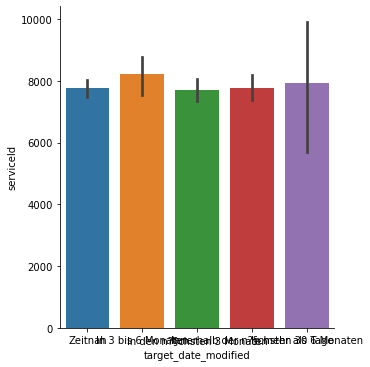

In [36]:
table = pd.crosstab(data_useful['target_date_modified'],data_useful['serviceId'],margins=True,normalize=True)
print(table)
sns.catplot(x="target_date_modified", y="serviceId", kind="bar", data=data_useful)

- using this field as relative distribution varies accross different serviceId and can be a potential predictor
- Will do onehotencoding for target_date_modified and tradeClassificationType to use in classifier

In [64]:
data_useful['tradeClassificationType'] = data_useful['tradeClassificationType'].astype('category')
dummy = pd.get_dummies(data_useful[['target_date_modified','tradeClassificationType']])
dummy.head(2)

,target_date_modified_In 3 bis 6 Monaten,target_date_modified_In den n?§chsten 3 Monaten,target_date_modified_In mehr als 6 Monaten,target_date_modified_Innerhalb der n?§chsten 30 Tage,target_date_modified_Zeitnah,tradeClassificationType_1.0,tradeClassificationType_2.0,tradeClassificationType_4.0
0,0,0,0,0,1,1,0,0
1,1,0,0,0,0,0,0,1


#### process and encoding target - serviceId

In [15]:
target = np.sort(data_useful['serviceId'].unique())
target
dic = {}
for i,j in enumerate(list(target)):
    dic[j] = i
data_useful['serviceId_coded'] = [dic[i] for i in data_useful['serviceId'].values] 
data_useful['serviceId_coded'] = data_useful['serviceId_coded'].astype('category')
data_useful['serviceId_coded'].value_counts()

2    202
5    113
6     87
3     81
4     55
0     44
7     25
8     19
1      8
Name: serviceId_coded, dtype: int64

### The next pipeline will be using FastText based NLP + benchmark classifier

In [32]:
vocab = data_useful['composite_text']
mod = gensim.models.FastText(data_useful['clean_txt'],size = 100,min_count=1)
fast_feat = pd.DataFrame(columns = range(100))
for i in range(len(data_useful)):
    fast_feat = fast_feat.append(pd.Series(np.mean(np.array([mod.wv.get_vector(w) for w in data_useful['clean_txt'][i]]),axis=0)),ignore_index=True)
fast_feat.columns = ['emb_%s' %(c) for c in range(1,101)]
print(fast_feat.shape)
fast_feat.head(1)

(634, 100)


,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100
0,0.169733,-0.263561,0.54202,-0.141467,0.087057,-0.538646,-0.176393,-0.29135,0.30833,-0.303533,...,-0.160147,-0.469023,-0.055718,-0.222184,0.070504,0.038511,0.602806,-0.450886,0.115621,0.664572


### Final model data with all features

-  Splitting training(85%) and validation(15%)

In [65]:
mod_data = pd.concat([dummy,fast_feat,data_useful['serviceId_coded']], axis=1)
train_X,validation_X,train_Y,validation_Y = train_test_split(mod_data.drop('serviceId_coded',axis=1),mod_data['serviceId_coded'],test_size = 0.15, random_state = 20)
print(train_X.shape,validation_X.shape,train_Y.shape,validation_Y.shape)

(538, 108) (96, 108) (538,) (96,)


##### Now we are ready to build model.This is a multi-classification problem.There are many m/c learning techniques- Decision Tree,Random Forest,Boosing techniques(GBM,XGBoost etc.),SVM etc. Here we will choose XGBoost as our algorithm.

##### XGBoost is also called regularized Gradient Boosting(an ensemble decision tree based algorithm) and in python it comes as an algorithm under sklearn package. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

#### FastText + base XGBoost classifier

In [79]:
xgb_model = xgb.XGBClassifier(n_estimators= 500, max_depth = 6, learning_rate=0.04,subsample=0.7,colsample_bytree=0.8,seed=100,objective= 'mlogloss',silent = False,tree_method = 'auto')

eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_xgb_fast = xgb_model.fit(train_X, train_Y,eval_set=eval_set,verbose = 10,early_stopping_rounds=50,
        eval_metric="mlogloss")

[0]	validation_0-mlogloss:2.10838	validation_1-mlogloss:2.12547
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[10]	validation_0-mlogloss:1.53922	validation_1-mlogloss:1.70611
[20]	validation_0-mlogloss:1.2111	validation_1-mlogloss:1.48587
[30]	validation_0-mlogloss:0.981947	validation_1-mlogloss:1.35682
[40]	validation_0-mlogloss:0.824536	validation_1-mlogloss:1.27289
[50]	validation_0-mlogloss:0.703433	validation_1-mlogloss:1.22001
[60]	validation_0-mlogloss:0.613106	validation_1-mlogloss:1.18657
[70]	validation_0-mlogloss:0.540828	validation_1-mlogloss:1.16336
[80]	validation_0-mlogloss:0.483189	validation_1-mlogloss:1.15052
[90]	validation_0-mlogloss:0.435371	validation_1-mlogloss:1.14141
[100]	validation_0-mlogloss:0.395418	validation_1-mlogloss:1.13059
[110]	validation_0-mlogloss:0.360133	validation_1-mlogloss:1.12314
[120]	validation_0-mlogloss:0.330285	validat

#### let's explore the result- accuracy and other stats

In [47]:
pred_y = mod_xgb_fast.predict(validation_X)
print(metrics.confusion_matrix(validation_Y,pred_y))

# Print the precision and recall, among other metrics
print(metrics.classification_report(validation_Y, pred_y, digits=3))

[[ 0  9  0  0  0  0  0  0]
 [ 1 28  1  0  0  0  0  0]
 [ 0 11  2  0  0  0  0  0]
 [ 0  0  0  3  0  2  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  1  0  7  0  0]
 [ 0  0  0  0  0  6  1  0]
 [ 0  0  0  3  0  1  0  0]]
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         9
           2      0.583     0.933     0.718        30
           3      0.667     0.154     0.250        13
           4      0.429     0.600     0.500         5
           5      1.000     1.000     1.000        20
           6      0.438     0.875     0.583         8
           7      1.000     0.143     0.250         7
           8      0.000     0.000     0.000         4

    accuracy                          0.635        96
   macro avg      0.515     0.463     0.413        96
weighted avg      0.613     0.635     0.559        96



- The benchmark FastText + base XGBoost classifier gave us accuracy of 0.635

#### Word2Vec + base XGBoost classifier

In [33]:
mod = gensim.models.Word2Vec(data_useful['clean_txt'],size = 100,min_count=1)
w2_v_feat = pd.DataFrame(columns = range(100))
for i in range(len(data_useful)):
    w2_v_feat = w2_v_feat.append(pd.Series(np.mean(np.array([mod.wv.get_vector(w) for w in data_useful['clean_txt'][i]]),axis=0)),ignore_index=True)
w2_v_feat.columns = ['emb_%s' %(c) for c in range(1,101)]
print(w2_v_feat.shape)
w2_v_feat.head(1)

(634, 100)


,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,...,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100
0,0.010038,-0.010688,-0.005885,-0.004623,-0.001823,0.001539,0.001909,-0.004098,0.002211,0.008223,...,-0.010339,0.005543,-0.00496,-0.006831,-0.009509,0.011986,0.00564,-0.010914,0.0002,0.00683


In [49]:
mod_data = pd.concat([dummy,w2_v_feat,data_useful['serviceId_coded']], axis=1)
train_X,validation_X,train_Y,validation_Y = train_test_split(mod_data.drop('serviceId_coded',axis=1),mod_data['serviceId_coded'],test_size = 0.15, random_state = 20)
print(train_X.shape,validation_X.shape,train_Y.shape,validation_Y.shape)
xgb_model = xgb.XGBClassifier(n_estimators= 500, max_depth = 7, learning_rate=0.04,subsample=0.8,colsample_bytree=0.7,seed=100,objective= 'mlogloss',silent = False,tree_method = 'auto')

eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_xgb_w2v = xgb_model.fit(train_X, train_Y,eval_set=eval_set,verbose = 10,early_stopping_rounds=50,
        eval_metric="merror")
pred_y = mod_xgb_w2v.predict(validation_X)
print(metrics.confusion_matrix(validation_Y,pred_y))

# Print the precision and recall, among other metrics
print(metrics.classification_report(validation_Y, pred_y, digits=3))

(538, 106) (96, 106) (538,) (96,)
[0]	validation_0-merror:0.165428	validation_1-merror:0.364583
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[10]	validation_0-merror:0.033457	validation_1-merror:0.34375
[20]	validation_0-merror:0.024164	validation_1-merror:0.3125
[30]	validation_0-merror:0.011152	validation_1-merror:0.322917
[40]	validation_0-merror:0.003717	validation_1-merror:0.3125
[50]	validation_0-merror:0	validation_1-merror:0.3125
Stopping. Best iteration:
[3]	validation_0-merror:0.076208	validation_1-merror:0.302083

[[ 1  6  2  0  0  0  0  0]
 [ 0 28  2  0  0  0  0  0]
 [ 0  7  6  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  1  0  7  0  0]
 [ 0  0  0  1  0  6  0  0]
 [ 0  0  0  1  0  3  0  0]]
              precision    recall  f1-score   support

           0      1.000     0.111     0.200         9
           2      0.683  

- The benchmark w2vec + base XGBoost classifier gave us accuracy of 0.698
- Keeping all other components same w2vec performance is better than FastText. So building the final classifier using w2vec based NLP embedding method

### Fine tuned w2vec + XGBoost classifier

#### First it's a good practice to normalize the embedding matrix. It will serve following two purposes.
- a) L2 is invariant under rotation and hence better for gradient-based learning methods.
- b) It will reduce the correlation amonst vectors

         0         1         2         3         4         5         6   \
0  1.000000 -0.910003 -0.849078 -0.716693 -0.334680  0.417825  0.585854   
1 -0.910003  1.000000  0.835835  0.755867  0.327040 -0.377602 -0.573092   
2 -0.849078  0.835835  1.000000  0.620569  0.319602 -0.354850 -0.557245   

         7         8         9   ...        90        91        92        93  \
0 -0.702578  0.673694  0.874056  ... -0.874498  0.824601 -0.781076 -0.849678   
1  0.734654 -0.666681 -0.897466  ...  0.870039 -0.806960  0.793606  0.862566   
2  0.671484 -0.620781 -0.823440  ...  0.793401 -0.751438  0.737482  0.805247   

         94        95        96        97        98        99  
0 -0.878842  0.877924  0.823257 -0.908652 -0.291450  0.854652  
1  0.901158 -0.914645 -0.846166  0.911034  0.240010 -0.860737  
2  0.841379 -0.829742 -0.793063  0.838218  0.227683 -0.794977  

[3 rows x 100 columns]


<AxesSubplot:>

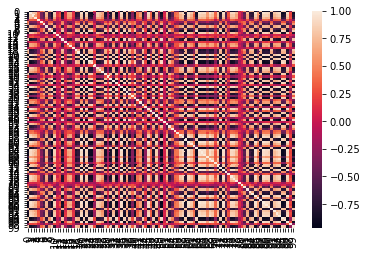

In [51]:
correlation_matrix = np.corrcoef(w2_v_feat.T)
correlation_matrix=pd.DataFrame(correlation_matrix)
print(correlation_matrix.head(3))
# plt.imshow(correlation_matrix,cmap='hot',interpolation='nearest',)
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns)

- The vector components are highly correlated

         0         1         2         3         4         5         6   \
0  1.000000  0.464971  0.454029  0.295764  0.350449  0.344064  0.268185   
1  0.464971  1.000000  0.347830  0.308931  0.277610  0.343692  0.429499   
2  0.454029  0.347830  1.000000  0.308518  0.217794  0.323172  0.357525   

         7         8         9   ...        90        91        92        93  \
0  0.559103  0.581747  0.439950  ... -0.015855  0.032038 -0.065549  0.083791   
1  0.245135  0.314149  0.394233  ... -0.045869 -0.023704 -0.033788  0.006492   
2  0.270004  0.515534  0.445695  ... -0.063217 -0.016739  0.009126  0.071270   

         94        95        96        97        98        99  
0  0.033305 -0.016944 -0.026445 -0.004512  0.010660  0.005069  
1  0.028819 -0.028785 -0.023963  0.022281  0.026168  0.027260  
2  0.001476  0.022939  0.046242  0.023355  0.007729  0.053704  

[3 rows x 100 columns]


<AxesSubplot:>

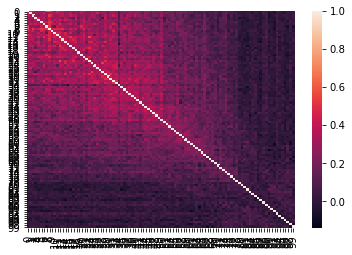

In [268]:
emb_normalized = sklearn.preprocessing.normalize(w2_v_feat, norm='l2')
correlation_matrix = np.corrcoef(emb_normalized.T)
correlation_matrix=pd.DataFrame(correlation_matrix)
print(correlation_matrix.head(3))
# plt.imshow(correlation_matrix,cmap='hot',interpolation='nearest',)
sns.heatmap(correlation_matrix, 
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns)
emb_normalized = pd.DataFrame(emb_normalized)
emb_normalized.columns = ['emb_%s' %(c) for c in range(1,101)]

- Now the correlation amongst vector components are greatly reduced and will use this normalised data for finetuned classifier

In [81]:
mod_data = pd.concat([dummy,emb_normalized,data_useful['serviceId_coded']], axis=1)
train_X,validation_X,train_Y,validation_Y = train_test_split(mod_data.drop('serviceId_coded',axis=1),mod_data['serviceId_coded'],test_size = 0.15, random_state = 20)
print(train_X.shape,validation_X.shape,train_Y.shape,validation_Y.shape)

(538, 108) (96, 108) (538,) (96,)


##### For building this model, as optimization strategy, we try to minimize merror and will monitor the accuracy.

##### We will try to train the model with grid search.For time constraint we will vary few key hyper parameters- depth,colsample,min_child_weight and subsample rate of XGB algorithm and will pick the hyper parameter setting,which will give maximum performance(low mlogloss).Of course there are many more hyper parameters we can play with.

In [82]:

ind_params = {'n_estimators': 300, 'seed':100,
             'objective': 'multi:softprob'}
ind_params['nthread'] = 4
ind_params['eval_metric'] = 'merror'
ind_params['num_class'] = data_useful['serviceId_coded'].nunique()
xgb_model = xgb.XGBClassifier(ind_params,seed=100)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [6,7,8],'subsample': [0.7,0.8], 'colsample_bytree': [0.7,0.8,0.9],'min_child_weight': [1,5],'learning_rate': [0.04],
                    }, verbose=2,cv=2,scoring='accuracy')
clf.fit(train_X, train_Y)
clf.best_estimator_

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.7, total=   1.2s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.7, total=   1.2s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.8, total=   1.3s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.8 
[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=6, min_child_weight=1, subsample=0.8, total=   1.3s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=7, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=7, min_child_weight=1, subsample=0.7, total=   1.2s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=7, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.7, learning_rate=0.04, max_depth=7, min_child_weight=1, subsample=0.7, total=   1.3s
[CV] colsample_bytree=0.7, learning_rate=0.04, max_depth=7, min_child_

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   51.6s finished


XGBClassifier(colsample_bytree=0.7, learning_rate=0.04, max_depth=6,
              objective='multi:softprob', seed=100, subsample=0.7)

In [84]:
clf.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.04,
 'max_depth': 6,
 'min_child_weight': 1,
 'subsample': 0.7}

### Final classifier with best hyperparameters

In [83]:
xgb_model = xgb.XGBClassifier(n_estimators= 500, max_depth = 6, learning_rate=0.04,subsample=0.7,min_child_weight = 1,colsample_bytree=0.7,seed=100,objective= 'merror',silent = False,tree_method = 'auto')

eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]

mod_bst = xgb_model.fit(train_X, train_Y,eval_set=eval_set,verbose = 10,early_stopping_rounds=80,
        eval_metric="merror")

[0]	validation_0-merror:0.213755	validation_1-merror:0.40625
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 80 rounds.
[10]	validation_0-merror:0.035316	validation_1-merror:0.291667
[20]	validation_0-merror:0.016729	validation_1-merror:0.28125
[30]	validation_0-merror:0.009294	validation_1-merror:0.270833
[40]	validation_0-merror:0.005576	validation_1-merror:0.25
[50]	validation_0-merror:0.001859	validation_1-merror:0.239583
[60]	validation_0-merror:0.001859	validation_1-merror:0.25
[70]	validation_0-merror:0.001859	validation_1-merror:0.25
[80]	validation_0-merror:0.001859	validation_1-merror:0.25
[90]	validation_0-merror:0.001859	validation_1-merror:0.25
[100]	validation_0-merror:0.001859	validation_1-merror:0.239583
[110]	validation_0-merror:0.001859	validation_1-merror:0.239583
[120]	validation_0-merror:0.001859	validation_1-merror:0.239583
[130]	validation_0-merror:0.001859	val

In [85]:
pred_y = mod_bst.predict(validation_X)
train_id,validation_id = train_test_split(data[['id']],test_size = 0.15, random_state = 20)
validation_dat = pd.DataFrame({'id':validation_id.values,'actual':validation_Y,'prediction':pred_y})
inv_dic = {v:k  for k,v in dic.items()}  
validation_dat['actual'] = [inv_dic[i] for i in validation_dat['actual'].values] 
validation_dat['prediction'] = [inv_dic[i] for i in validation_dat['prediction'].values] 
validation_dat.to_csv('valid_actual_pred.csv',index=False)
print(metrics.confusion_matrix(validation_Y,pred_y))

# Print the precision and recall, among other metrics
print(metrics.classification_report(validation_Y, pred_y, digits=3))

[[ 3  6  0  0  0  0  0  0]
 [ 0 29  1  0  0  0  0  0]
 [ 0  6  7  0  0  0  0  0]
 [ 0  0  0  4  0  1  0  0]
 [ 0  0  0  0 20  0  0  0]
 [ 0  0  0  0  0  8  0  0]
 [ 0  0  0  2  0  3  2  0]
 [ 0  0  0  0  0  3  0  1]]
              precision    recall  f1-score   support

           0      1.000     0.333     0.500         9
           2      0.707     0.967     0.817        30
           3      0.875     0.538     0.667        13
           4      0.667     0.800     0.727         5
           5      1.000     1.000     1.000        20
           6      0.533     1.000     0.696         8
           7      1.000     0.286     0.444         7
           8      1.000     0.250     0.400         4

    accuracy                          0.771        96
   macro avg      0.848     0.647     0.656        96
weighted avg      0.835     0.771     0.746        96



### So with further l2 normalization and hyperparameter tuning there is the clissifier accuracy is improved from 69.8% to 77.1%(10.46% improvement)

### Also as a imbalance classifier other metrics like f1-score,recall and precision are improved in both classwise and in overall.   

In [34]:
#sneap-peak of prediction
validation_dat.head(10)

,id,actual,prediction
0,19080202,9010,9010
1,19063787,7010,7010
2,14615528,7010,7010
3,19055877,7010,7010
4,19067567,7010,7010
5,18908617,7060,7060
6,18976157,7010,7010
7,19074852,10010,10010
8,18962547,9010,9010
9,19068247,1060,1060


## Variable of Importance

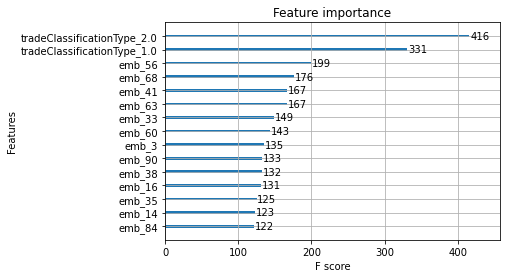

<Figure size 2160x2160 with 0 Axes>

In [87]:
#plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot as plt
plot_importance(mod_bst,max_num_features=15)
plt.figure(figsize=(30,30))
plt.show()

### Further improvement strategy: With more time and with large data following improvement strategies are worth exploring 
 - PCA(Principla Component Analysis) based decorrelation of the embedding vector space
 - Try with other NLP embedding feature extraction eg. tensorflow.keras embedding layer, GloVe(Global Vectors for Word Representation) etc. and build final classifier using those embedding vectors
 - Try with different clasifier algorithm- RandomForrest, LightGBM,CatGBM etc.
 - As a NLP based classifier with massive dataset the Keras-LSTM(Long short-term memory) (LSTM) based artificial recurrent neural network (RNN) architecture can be explored

## The final ML pipeline- a light ready to implement classifier pipeline

In [ ]:
selected_fields = ['id', 'title', 'description','user_description','serviceId','createdAt','target_date','tradeClassificationType','sbf_form_text']
nlp_field = ['title', 'description']
target_col_orig = 'serviceId'
data_path = 'nlp_dat_classif.csv'
model_path = mod_path
language = 'german'
nlp_recipe = gensim.models.Word2Vec
classifier = xgb.XGBClassifier
class nlp_classif:
    def __init__(self, cv=3,data_split = 0.15,target_col_orig = target_col_orig,data_path = data_path,language=language,\
                 nlp_recipe = nlp_recipe,seed=100,classifier = xgb.XGBClassifier):
        self.cv = cv
        self.target_col_orig = target_col_orig
        self.data_path = data_path
        self.language = language
        self.nlp_recipe = nlp_recipe
        self.data_split = data_split
        self.seed = seed
        self.classifier=classifier
    def data_preprocess(self):
        data = pd.read_csv(data_path,encoding='ISO-8859-1')
        data_useful = data[selected_fields]
        data_useful = data_useful.replace(np.nan, '', regex=True)
        data_useful.createdAt = pd.to_datetime(data_useful.createdAt)
        l = []
        for i in range(len(data_useful)):
            if data_useful.target_date[i].split(':')[0] == 'Wunschtermin':
                d = (pd.to_datetime(data_useful.target_date[i].split(':')[1].strip())-pd.to_datetime(data_useful.createdAt[i])).days 
                s = str(np.where(d<30,'Innerhalb der n?§chsten 30 Tage', np.where(30<d<=90,'In den n?§chsten 3 Monaten','In 3 bis 6 Monaten')))
                l.append(s)
            else:
                l.append(data_useful.target_date[i])
        data_useful['target_date_modified'] = pd.Series(l)
        target = np.sort(data_useful['serviceId'].unique())
        dic = {}
        for i,j in enumerate(list(target)):
            dic[j] = i
        data_useful['serviceId_coded'] = [dic[i] for i in data_useful[self.target_col_orig].values] 
        data_useful['serviceId_coded'] = data_useful['serviceId_coded'].astype('category')
        return data_useful 
    def nlp_processor(self,data_useful):
        data_useful['composite_text'] = data['title'] + data['description'].map(str)
        data_useful['composite_text'] = [re.sub("@[\w]*",'',str(data_useful.composite_text.values[i])).strip() for i in range(len(data_useful))] 
        data_useful['composite_text'] = [re.sub("\d",'',str(data_useful.composite_text.values[i])).strip() for i in range(len(data_useful))] 
        data_useful['composite_text'] = [str(data_useful.composite_text.values[i]).lower().strip() for i in range(len(data_useful))] 
        table = str.maketrans('', '', string.punctuation)
        data_useful['clean_txt'] = data_useful['composite_text'].apply(lambda x: [w.translate(table) for w in x.split(' ') if w not in('.','')])
        # stop_words = stopwords.words(self.language)
        data_useful['clean_txt'] = data_useful['clean_txt'].apply(lambda x: [w for w in x if w not in(stop_words)])
        mod = self.nlp_recipe(data_useful['clean_txt'],size = 100,min_count=1)
        w2_v_feat = pd.DataFrame(columns = range(100))
        for i in range(len(data_useful)):
            w2_v_feat = w2_v_feat.append(pd.Series(np.mean(np.array([mod.wv.get_vector(w) for w in data_useful['clean_txt'][i]]),axis=0)),ignore_index=True)
        w2_v_feat.columns = ['emb_%s' %(c) for c in range(1,101)]
        emb_normalized = sklearn.preprocessing.normalize(w2_v_feat, norm='l2')
        emb_normalized = pd.DataFrame(emb_normalized)
        emb_normalized.columns = ['emb_%s' %(c) for c in range(1,101)]
        return data_useful,emb_normalized
    def final_mod_data_prep(self,data_useful,emb_normalized):
        data_useful['tradeClassificationType'] = data_useful['tradeClassificationType'].astype('category')
        dummy = pd.get_dummies(data_useful[['target_date_modified','tradeClassificationType']])
        mod_data = pd.concat([dummy,emb_normalized,data_useful['serviceId_coded']], axis=1)
        train_X,validation_X,train_Y,validation_Y = train_test_split(mod_data.drop('serviceId_coded',axis=1),mod_data['serviceId_coded'],test_size = self.data_split, random_state = self.seed)
        print(train_X.shape,validation_X.shape,train_Y.shape,validation_Y.shape)
        return train_X,validation_X,train_Y,validation_Y
     def cv_fine_tuned_mod(self,train_X,validation_X,train_Y,validation_Y):
        ind_params = {'n_estimators': 300, 'seed':100,
             'objective': 'multi:softprob'}
        ind_params['nthread'] = 4
        ind_params['eval_metric'] = 'merror'
        ind_params['num_class'] = data_useful['serviceId_coded'].nunique()
        xgb_model = self.classifier(ind_params,seed=100)
        clf = GridSearchCV(xgb_model,
                   {'max_depth': [6,7,8],'subsample': [0.7,0.8], 'colsample_bytree': [0.7,0.8,0.9],'min_child_weight': [1,5],'learning_rate': [0.04],
                    }, verbose=2,cv=self.cv,scoring='accuracy')
        clf.fit(train_X, train_Y)
        print(clf.best_params_)
        print(clf.best_score_)
        bst = clf.best_estimator_
        eval_set  = [(train_X,train_Y), (validation_X,validation_Y)]
        mod_bst = bst.fit(train_X, train_Y,eval_set=eval_set,verbose = 10,early_stopping_rounds=80,
        eval_metric="merror")
        pred_y = mod_bst.predict(validation_X)
        train_id,validation_id = train_test_split(data[['id']],test_size = 0.15, random_state = 20)
        validation_dat = pd.DataFrame({'id':validation_id.values,'actual':validation_Y,'prediction':pred_y})
        inv_dic = {v:k  for k,v in dic.items()}  
        validation_dat['actual'] = [inv_dic[i] for i in validation_dat['actual'].values] 
        validation_dat['prediction'] = [inv_dic[i] for i in validation_dat['prediction'].values] 
        validation_dat.to_csv('valid_actual_pred.csv',index=False)
        print(metrics.confusion_matrix(validation_Y,pred_y))
        print(metrics.classification_report(validation_Y, pred_y, digits=3))
        return mod_bst

In [ ]:
if __name__ == '__main__':
    data = pd.read_csv(data_path,encoding='ISO-8859-1')
    nc = nlp_classif()
    data_useful = nc.data_preprocess()
    data_useful,emb_feat = nc.nlp_processor(data_useful)
    train_X,validation_X,train_Y,validation_Y = nc.final_mod_data_prep(data_useful,emb_feat)
    mod = nc.cv_fine_tuned_mod(train_X,validation_X,train_Y,validation_Y)
    with open(os.path.join(mod_path,'serviceid_classif.pickle'), 'wb') as f:
        pickle.dump(clf, f)

##  Thank You! Open for Questions